In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
print(os.listdir("../input"))
import matplotlib.pyplot as plt
import cv2
import sklearn
import seaborn as sb

from skimage.color import rgb2gray
from skimage.filters import laplace, sobel, roberts

['blur-dataset']


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
print('Sobel operator:\n',np.matrix([[1,0,-1],[2,0,-2],[1,0,-1]]))
print('Laplacian operator:\n',np.matrix([[0,-1,0],[-1,4,-1],[0,-1,0]]))

Sobel operator:
 [[ 1  0 -1]
 [ 2  0 -2]
 [ 1  0 -1]]
Laplacian operator:
 [[ 0 -1  0]
 [-1  4 -1]
 [ 0 -1  0]]


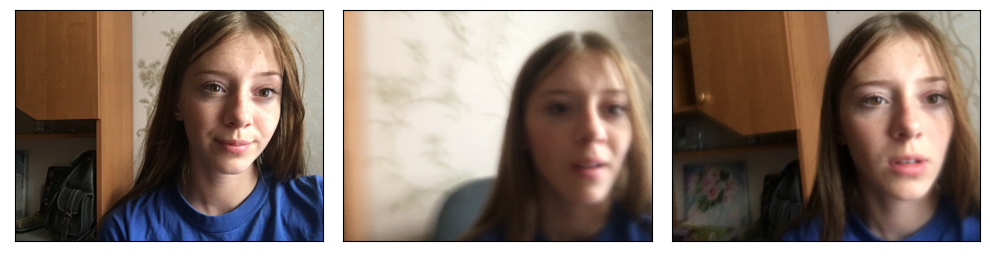

In [4]:
s_path ='../input/blur-dataset/sharp/'
df_path='../input/blur-dataset/defocused_blurred/'
mot_path ='../input/blur-dataset/motion_blurred/'

img_paths = ['../input/blur-dataset/sharp/89_IPHONE-6S_S.jpeg','../input/blur-dataset/defocused_blurred/89_IPHONE-6S_F.jpeg','../input/blur-dataset/motion_blurred/89_IPHONE-6S_M.jpeg']
 
def show_images(path):
    plt.figure(figsize=(10,10))
    for i in range(len(path)):
        x=plt.imread(path[i])
        plt.subplot(1, 3, i+1)
        plt.imshow(x)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    plt.show()
show_images(img_paths)

In [5]:
sharp_images = os.listdir(s_path)
defocused = os.listdir(df_path)
motion_blurred = os.listdir(mot_path)

In [6]:
from skimage.filters import laplace
from scipy.ndimage import variance
def get_data(path,images):
    features=[]
    for img in images:
        feature=[]
        gray = cv2.imread(path+img,0)
        edge_laplace = laplace(gray, ksize=3)
        laplacian_var = variance(edge_laplace)
        laplacian_max = np.amax(edge_laplace)
        feature.append(laplacian_var)
        feature.append(laplacian_max)
        features.append(feature)
    return features

In [7]:
sharp_features = get_data(s_path,sharp_images)
defocused_features = get_data(df_path,defocused)
motion_blur_features = get_data(mot_path,motion_blurred)
sharp_df = pd.DataFrame(sharp_features)
print(sharp_df[:10])

          0         1
0  0.004658  1.721569
1  0.072154  1.941176
2  0.011369  2.337255
3  0.025105  3.411765
4  0.003088  2.490196
5  0.000792  0.792157
6  0.002206  1.819608
7  0.004760  1.101961
8  0.000457  0.694118
9  0.019647  1.878431


In [8]:
defocused_df = pd.DataFrame(defocused_features)
defocused_df.head()

,0,1
0,0.000300,0.176471
1,0.001335,0.564706
2,0.000391,0.388235
3,0.000890,0.619608
4,0.000350,0.403922


In [9]:
motion_df = pd.DataFrame(motion_blur_features)
motion_df.head()


,0,1
0,0.001511,0.380392
1,0.000650,0.592157
2,0.000887,1.152941
3,0.000856,2.054902
4,0.002391,0.874510


In [10]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score, classification_report

images=pd.DataFrame()
images = images.append(sharp_df)
images = images.append(defocused_df)
images = images.append(motion_df)
all_features = np.array(images)
y_f = np.concatenate((np.ones((sharp_df.shape[0], )), np.zeros((defocused_df.shape[0]+motion_df.shape[0], ))), axis=0)

x_train,x_valid,y_train,y_valid = train_test_split(all_features,y_f,test_size=0.33,stratify=y_f)

svm_model = svm.SVC(kernel='rbf', C=100000)
svm_model.fit(x_train,y_train)
pred =svm_model.predict(x_valid)
print('Accuracy:',accuracy_score(y_valid,pred))

/tmp/ipykernel_21/3046427655.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  images = images.append(sharp_df)
/tmp/ipykernel_21/3046427655.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  images = images.append(defocused_df)
/tmp/ipykernel_21/3046427655.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  images = images.append(motion_df)


Accuracy: 0.8213256484149856
